## Testing for Lead Sheet to Multi-Track Arrangement

#### Loading modules

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']= '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import scipy
import pretty_midi as pyd
from tqdm import tqdm
import scipy.stats as st
import mir_eval
import torch

import sys
sys.path.append('piano_arranger/chord_recognition')
from main import transcribe_cb1000_midi
from orchestrator.utils import midi2matrix

import warnings
warnings.filterwarnings("ignore")

#The polydis encoder is needed for calculating structure awareness
from piano_arranger.models.Poly_Dis import DisentangleVAE
polydis_model = DisentangleVAE.init_model()
polydis_param_path = "/data1/zhaojw/data_file_dir/model_master_final.pt"
polydis_model.load_model(polydis_param_path)

#### Evaluation Metrics and Functionals

In [7]:

ACC = 4
DEVICE = 'cuda:0'
cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

def load_sim_mat(path, melody_id=None, phrase_annotation=None):
    multi_track = pyd.PrettyMIDI(path)
    beats = multi_track.get_beats()
    beats = np.append(beats, beats[-1] + (beats[-1] - beats[-2]))
    quantize = scipy.interpolate.interp1d(np.array(range(0, len(beats))) * ACC, beats, kind='linear')
    quaver = quantize(np.array(range(0, (len(beats) - 1) * ACC)))
    multi_track, program = midi2matrix(multi_track, quaver) #multi_track: (n_track, time, 128)
    if melody_id is not None:
        if melody_id == 'AMT':
            melody_id = np.argmax(program == 1)
        multi_track = np.delete(multi_track, melody_id, axis=0)

    total_len = sum([int(item[0][1:]) for item in phrase_annotation])
    if multi_track.shape[1] < total_len * 16:
        pad_len = total_len * 16 - multi_track.shape[1]
        multi_track = np.concatenate([multi_track, np.zeros((len(multi_track), pad_len, 128))], axis=1)
    multi_track = multi_track[:, :total_len * 16]
        
    if phrase_annotation is not None:
        phrase_split = []
        start = 0
        for phrase in phrase_annotation:
            length = int(phrase[0][1:])
            one_phrase = multi_track[:, start*16: (start + length)* 16]
            if (length % 2) != 0:
                one_phrase = np.concatenate([one_phrase, one_phrase[:, -16:]], axis=1)
            phrase_split.append(one_phrase)
            start += length
    multi_track = np.concatenate(phrase_split, axis=1)
    mixture = torch.from_numpy(np.max(multi_track, axis=0)).reshape(-1, 32, 128).to(DEVICE).float()
    z_mix = polydis_model.rhy_encoder(mixture).mean
    sim_mat = cos(z_mix.unsqueeze(0), z_mix.unsqueeze(1))
    return sim_mat

def structure_awareness(sim_mat, phrase):
    #sim_mat: (num_segment, num_segment)
    assert(sim_mat.shape[0]==sim_mat.shape[1])
    for i in range(sim_mat.shape[0]):
        sim_mat[i, i] = 0
    sim_sum = torch.sum(sim_mat).item()
    total_num = sim_mat.shape[0] * (sim_mat.shape[0] - 1)
    same_type = 0.0
    s_sum = 0
    for i, (tp_i, start_i, end_i) in enumerate(phrase):
        for j, (tp_j, start_j, end_j) in enumerate(phrase):
            if (tp_i == tp_j):
                if (i == j):
                    same_type += torch.sum(sim_mat[start_i:end_i, start_j:end_j]).item() - torch.trace(sim_mat[start_i:end_i, start_j:end_j]).item()
                    s_sum += (end_i - start_i) * (end_j - start_j - 1)
                else:
                    same_type += torch.sum(sim_mat[start_i:end_i, start_j:end_j]).item()
                    s_sum += (end_i - start_i) * (end_j - start_j)
    if s_sum == 0:
        return None
    else: 
        ILS = (same_type / s_sum) / (sim_sum / total_num)
        return ILS


def load_pitch_hist(path, melody_id=None):
    orchestration = pyd.PrettyMIDI(path)
    beats = orchestration.get_beats()
    beats = np.append(beats, beats[-1] + (beats[-1] - beats[-2]))
    quantize = scipy.interpolate.interp1d(np.array(range(0, len(beats))) * ACC, beats, kind='linear')
    quaver = quantize(np.array(range(0, (len(beats) - 1) * ACC)))
    orchestration, prog = midi2matrix(orchestration, quaver) #orchestration: (n_track, time, 128)
    orchestration = orchestration[:, :orchestration.shape[1]//32*32]
    if melody_id is not None:
        if melody_id == 'AMT':
            melody_id = np.argmax(prog == 1)   #for AMT
        orchestration = np.delete(orchestration, melody_id, axis=0)

    trivial_trakcs = np.nonzero(np.sum(orchestration > 0, axis=(-2, -1)) < 2)[0]
    orchestration = np.delete(orchestration, trivial_trakcs, axis=0)
    
    pitch_hist = np.sum((orchestration[:, :, :120]>0).reshape(len(orchestration), -1, 10, 12), axis=-2)
    pitch_hist = np.sum(pitch_hist.reshape(len(orchestration), -1, 16, 12), axis=-2)

    pitch_hist_pno_red = np.sum((np.max(orchestration[:, :, :120]>0, axis=0)).reshape(-1, 10, 12), axis=-2)
    pitch_hist_pno_red = np.sum(pitch_hist_pno_red.reshape(1, -1, 16, 12), axis=-2)
    return pitch_hist, pitch_hist_pno_red


def kl_div(his_track, his_mix):
    div = st.entropy(pk=his_track, qk=his_mix, axis=-1)

    div= np.nanmean(div, axis=-1)
    div = np.nanstd(div)
    return div


def chord_comparator(path, name):
    chord_1 = []
    chord = transcribe_cb1000_midi(os.path.join(path, 'lead_sheet.mid'), extra_division=1, output_path=None)
    INCRE = 60 / pyd.PrettyMIDI(os.path.join(path, 'lead_sheet.mid')).get_tempo_changes()[1][0]
    for item in chord:
        chord_1 += [item[-1].split('/')[0]]*int(round((item[1]-item[0]) / INCRE))
    chord_2 = []
    chord = transcribe_cb1000_midi(os.path.join(path, f'{name}.mid'), extra_division=1, output_path=None)
    INCRE = 60 / pyd.PrettyMIDI(os.path.join(path, f'{name}.mid')).get_tempo_changes()[1][0]
    for item in chord:
        chord_2 += [item[-1].split('/')[0]]*int(round((item[1]-item[0]) / INCRE))
    if not (len(chord_1) == len(chord_2)):
        chord_len = min(len(chord_1), len(chord_2))
        chord_1 = chord_1[:chord_len]
        chord_2 = chord_2[:chord_len]
    result = 0
    for i in range(len(chord_1)):
        if (mir_eval.chord.encode(chord_1[i])[1] == mir_eval.chord.encode(chord_2[i])[1]).all():
            result += 1
    result = result / len(chord_1)
    return result

#### Objective Evaluation

In [8]:
#Load phrase label for each testing piece.
#These phrase labels are precomputed by https://github.com/Dsqvival/hierarchical-structure-analysis
SONG_ROOT="test/test_samples"
phrase_dict = {}
for SONG_NAME in os.listdir(SONG_ROOT):
    with open(os.path.join(SONG_ROOT, SONG_NAME, 'phrases.txt')) as f:
        SEGMENTATION = f.readlines()[0]
    phrases = []
    lengths = []
    current = 0
    while SEGMENTATION[current] != '\n':
        if SEGMENTATION[current].isalpha():
            j = 1
            while not (SEGMENTATION[current + j].isalpha() or SEGMENTATION[current + j] == '\n'):
                j += 1
            phrases.append(SEGMENTATION[current: current+j])
            lengths.append(int(SEGMENTATION[current+1: current+j]))
            current += j
    phrase_dict[SONG_NAME] = []
    shift = 0
    for i in range(len(phrases)):
        if (lengths[i] % 2) != 0:
            phrase_dict[SONG_NAME].append((phrases[i], (sum(lengths[:i])+shift)//2, (sum(lengths[:i])+lengths[i]+shift+1)//2))
            shift += 1
        else:
            phrase_dict[SONG_NAME].append((phrases[i], (sum(lengths[:i])+shift)//2, (sum(lengths[:i])+lengths[i]+shift)//2))


results = {'Ours': {'structure': [], 'doa': [], 'chd_acc': []}, \
           'AMT': {'structure': [], 'doa': [], 'chd_acc': []}, \
           'PopMAG': {'structure': [], 'doa': [], 'chd_acc': []},\
           'GETMusic': {'structure': [], 'doa': [], 'chd_acc': []}
           }
melody_id_dict = {'Ours':-1, 'AMT':'AMT', 'PopMAG':0, 'GETMusic': -1}
for demo in [1, 2, 3]:
    demo_root = f"test/demo_{demo}"
    for song in tqdm(os.listdir(demo_root)):
        phrase = phrase_dict[song.split('-')[0]]

        for model in ['Ours', 'AMT', 'PopMAG', 'GETMusic']:
            try:
                histo_orch, histo_red = load_pitch_hist(os.path.join(demo_root, song, f'{model}.mid'), melody_id_dict[model])
            except Exception as error:
                print("An exception occurred:", error)
                results[model]['doa'].append(0)
                results[model]['chd_acc'].append(0)
                results[model]['structure'].append(0)
                continue

            results[model]['doa'].append(kl_div(histo_orch, histo_red))
            results[model]['chd_acc'].append(chord_comparator(os.path.join(demo_root, song), model))

            sim_mat = load_sim_mat(os.path.join(demo_root, song, f'{model}.mid'), melody_id=melody_id_dict[model], phrase_annotation=phrase)
            ILS = structure_awareness(sim_mat, phrase)
            if ILS is None:
                continue
            else:
                results[model]['structure'].append(ILS)

for key in results:
    print(f"{key}\t structure={np.mean(results[key]['structure']):.5f} + {st.sem(results[key]['structure']):.5f}\t\
                    doa={np.mean(results[key]['doa']):.5f} + {st.sem(results[key]['doa']):.5f}\t\
                    chd_acc={np.mean(results[key]['chd_acc']):.5f} + {st.sem(results[key]['chd_acc']):.5f}")

 91%|█████████ | 91/100 [02:01<00:11,  1.32s/it]

An exception occurred: [Errno 2] No such file or directory: 'test/demo_3/068/AMT.mid'


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Ours	 structure=1.51890 + 0.02958	                    doa=0.29960 + 0.00472	                    chd_acc=0.56378 + 0.01433
AMT	 structure=1.09428 + 0.00949	                    doa=0.29389 + 0.00642	                    chd_acc=0.44616 + 0.01260
PopMAG	 structure=1.08616 + 0.00829	                    doa=0.26998 + 0.00669	                    chd_acc=0.47046 + 0.01271
GETMusic	 structure=1.24335 + 0.01722	                    doa=0.22523 + 0.00691	                    chd_acc=0.42334 + 0.01194


#### Test statistical significnace

In [8]:
print('structure awareness')
print(st.wilcoxon(results['Ours']['structure'], results['GETMusic']['structure'], alternative='greater'))
print(st.wilcoxon(results['Ours']['structure'], results['PopMAG']['structure'], alternative='greater'))
print(st.wilcoxon(results['Ours']['structure'], results['GETMusic']['structure'], alternative='greater'))
print(st.wilcoxon(results['GETMusic']['structure'], results['AMT']['structure'], alternative='greater'))
print(st.wilcoxon(results['AMT']['structure'], results['PopMAG']['structure'], alternative='greater'))

print('DOA')
print(st.wilcoxon(results['Ours']['doa'], results['AMT']['doa'], alternative='greater'))
print(st.wilcoxon(results['Ours']['doa'], results['PopMAG']['doa']))
print(st.wilcoxon(results['Ours']['doa'], results['GETMusic']['doa'], alternative='greater'))
print(st.wilcoxon(results['AMT']['doa'], results['PopMAG']['doa']))
print(st.wilcoxon(results['PopMAG']['doa'], results['GETMusic']['doa'], alternative='greater'))

print('Chord Accuracy')
print(st.wilcoxon(results['Ours']['chd_acc'], results['AMT']['chd_acc'], alternative='greater'))
print(st.wilcoxon(results['Ours']['chd_acc'], results['PopMAG']['chd_acc'], alternative='greater'))
print(st.wilcoxon(results['Ours']['chd_acc'], results['GETMusic']['chd_acc'], alternative='greater'))
print(st.wilcoxon(results['PopMAG']['chd_acc'], results['AMT']['chd_acc'], alternative='greater'))
print(st.wilcoxon(results['AMT']['chd_acc'], results['GETMusic']['chd_acc'], alternative='greater'))

structure awareness
WilcoxonResult(statistic=33563.0, pvalue=5.847096715907704e-17)
WilcoxonResult(statistic=40949.0, pvalue=4.254598878033501e-42)
WilcoxonResult(statistic=33563.0, pvalue=5.847096715907704e-17)
WilcoxonResult(statistic=32971.0, pvalue=1.6589070838053046e-15)
WilcoxonResult(statistic=22967.0, pvalue=0.1372580691526495)
DOA
WilcoxonResult(statistic=25472.0, pvalue=0.027019881565803414)
WilcoxonResult(statistic=15789.0, pvalue=6.400156258640813e-06)
WilcoxonResult(statistic=35436.0, pvalue=6.016202598429237e-18)
WilcoxonResult(statistic=17978.0, pvalue=0.0022354550947138473)
WilcoxonResult(statistic=30539.0, pvalue=5.915267589054714e-08)
Chord Accuracy
WilcoxonResult(statistic=35301.0, pvalue=6.195493995048505e-25)
WilcoxonResult(statistic=37032.5, pvalue=8.52406928243548e-25)
WilcoxonResult(statistic=37420.5, pvalue=1.0560815109318543e-26)
WilcoxonResult(statistic=23883.0, pvalue=0.02565685211027289)
WilcoxonResult(statistic=24234.5, pvalue=0.0505259320130365)


#### Ground-Truth Structure Awareness

In [8]:
GT = []
phrase_data_dir = '/data1/zhaojw/POP909/POP909 Phrase Split Data/Phrase Split Data/'    #POP909 with groundtruth phrase label by https://github.com/Dsqvival/hierarchical-structure-analysis
for item in tqdm(os.listdir(phrase_data_dir)):
    phrase_label = ''
    phrase_data = []
    phrases = os.listdir(os.path.join(phrase_data_dir, item))
    phrases.remove('midi')
    phrases.remove('phrase_sections.txt')
    phrases.sort(key=lambda x: int(x.split('_')[0]))
    for phrase in phrases:
        if not '.npz' in phrase:
            continue
        data = np.load(os.path.join(phrase_data_dir, item, phrase))
        data = np.max(np.stack((data['bridge'], data['piano']), axis=-1), axis=-1)

        phrase_label += phrase.split('_')[-1].replace('.npz', '')
        phrase_data.append(data)
    phrase_label += '\n'

    phrases = []
    lengths = []
    current = 0
    while phrase_label[current] != '\n':
        if phrase_label[current].isalpha():
            j = 1
            while not (phrase_label[current + j].isalpha() or phrase_label[current + j] == '\n'):
                j += 1
            phrases.append(phrase_label[current: current+j])
            lengths.append(int(phrase_label[current+1: current+j]))
            current += j

    phrase_dict = []
    shift = 0
    for i in range(len(phrases)):
        if (lengths[i] % 2) != 0:
            phrase_dict.append((phrases[i], (sum(lengths[:i])+shift)//2, (sum(lengths[:i])+lengths[i]+shift+1)//2))
            shift += 1
        else:
            phrase_dict.append((phrases[i], (sum(lengths[:i])+shift)//2, (sum(lengths[:i])+lengths[i]+shift)//2))

    start = 0
    for idx, phrase in enumerate(phrase_dict):
        length = int(phrase[0][1:])
        if (length % 2) != 0:
            phrase_data[idx] = np.concatenate([phrase_data[idx], phrase_data[idx][-16:]], axis=0)
        start += length

    multi_track = np.concatenate(phrase_data, axis=0)
    mixture = torch.from_numpy(multi_track).reshape(-1, 32, 128).to(DEVICE).float()
    z_mix = polydis_model.rhy_encoder(mixture).mean
    sim_mat = cos(z_mix.unsqueeze(0), z_mix.unsqueeze(1))

    ILS = structure_awareness(sim_mat, phrase_dict)
    GT.append(ILS)

print(f"GT structure={np.mean(GT):.5f} + {st.sem(np.array(GT)):.5f}")

100%|██████████| 857/857 [00:21<00:00, 38.98it/s]

GT structure=1.97992 + 0.01905


#### Visualize Structure Awareness Distribution

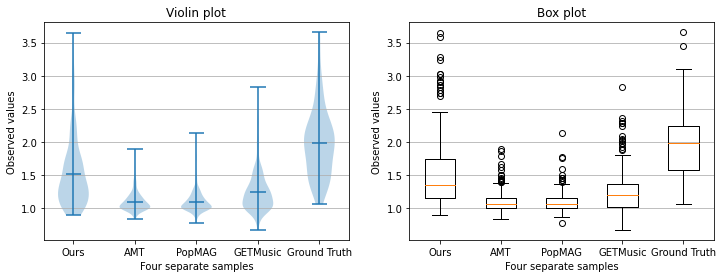

In [45]:
import matplotlib.pyplot as plt
import numpy as np

all_data = [results[key]['structure'] for key in results] + [GT]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# plot violin plot
axs[0].violinplot(all_data,
                  showmeans=True,
                  showmedians=False)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(all_data)
axs[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['Ours', 'AMT', 'PopMAG', 'GETMusic', 'Ground Truth'])
    ax.set_xlabel('Four separate samples')
    ax.set_ylabel('Observed values')

plt.show()

#### Visualize Chord Accuracy Distribution

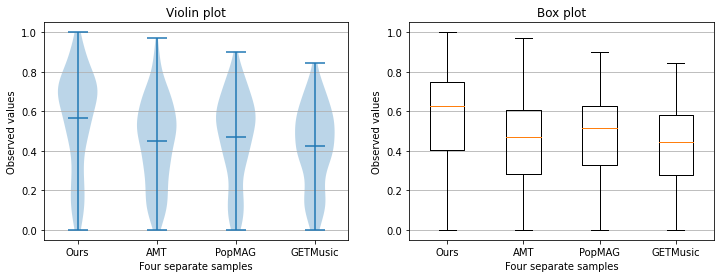

In [46]:
import matplotlib.pyplot as plt
import numpy as np


all_data = [results[key]['chd_acc'] for key in results]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# plot violin plot
axs[0].violinplot(all_data,
                  showmeans=True,
                  showmedians=False)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(all_data)
axs[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['Ours', 'AMT', 'PopMAG', 'GETMusic'])
    ax.set_xlabel('Four separate samples')
    ax.set_ylabel('Observed values')

plt.show()

#### Ground-Truth DOA

In [3]:
demo_root = "/data1/zhaojw/Q&A/slakh2100_flac_redux/full_midi/test/"
GT_DOA = []
for song in tqdm(os.listdir(demo_root)):
    histo_orch, histo_orch_pno_red = load_pitch_hist(os.path.join(demo_root, song, 'all_src.mid'), melody_id=None)
    doa = kl_div(histo_orch, histo_orch_pno_red)
    if not np.isnan(doa):
        GT_DOA.append(doa)

print(f"GT DOA={np.mean(GT_DOA):.5f} + {st.sem(GT_DOA):.5f}")

100%|██████████| 151/151 [00:36<00:00,  4.11it/s]

GT DOA=0.35160 + 0.01118


#### Visualize DOA Distribution

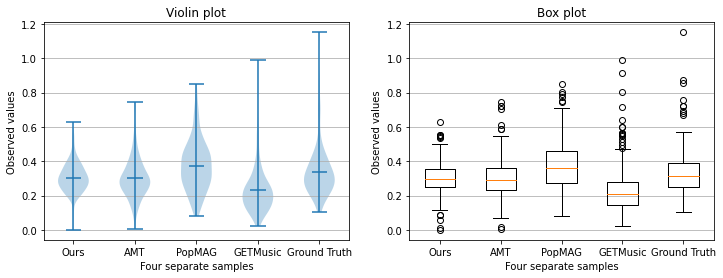

In [56]:
import matplotlib.pyplot as plt
import numpy as np


all_data = [results[key]['doa-p'] for key in results] + [GT_DOA]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# plot violin plot
axs[0].violinplot(all_data,
                  showmeans=True,
                  showmedians=False)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(all_data)
axs[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                  labels=['Ours', 'AMT', 'PopMAG', 'GETMusic', 'Ground Truth'])
    ax.set_xlabel('Four separate samples')
    ax.set_ylabel('Observed values')

plt.show()